# Expected Value, Variance, and Distribution of Throne of Eldraine Sealed Product

This Notebook will be a refreshable source of data that will guide purchasing decisions for those who want to know how much value they expect to get from a given sealed box (or pack!) of magic product. We'll start with Throne of Eldraine for recency.

In [1]:
import pandas as pd
import numpy as np
import string
import random
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import random as rd
import time
import matplotlib.pyplot as plt

In [2]:
##Scrape prices from Cardsphere

#Functions
def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None


def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)


In [3]:
#Test get function
rawhtml = simple_get(r'https://www.cardsphere.com/cards/16416')
len(rawhtml)

15467

In [5]:
html = BeautifulSoup(rawhtml, 'html.parser')

The only way to proceed really is to dive into that html and find the tags of the objects you are looking for. You can use .prettify() if you really want to see the source. I found it was easier however to just navigate to the webpage and use Chrome (or firefox or opera) to left click the object and 'inspect element'. Then you can do more targeted looks as I do below.

For the first step, Im just printing the HTML I am grabbing from at the same time as I am saving the data I want into a dataframe.

In [6]:
dfp = pd.DataFrame(columns=['Price'])
for d in html.select('div'):
    try:
        if d['class'] == ['cs-col-xs-4','cs-col-sm-4']:
            print(d.text)
            dfp = dfp.append({'Price':d.text.strip()}, ignore_index=True)
    except:
        print('Error')
        print(d)

Error
<div id="add-want-dialog-vue"></div>
Error
<div id="add-have-dialog-vue"></div>

                        $0.16
                    

                        $0.32
                    

                        $0.32
                    

                        $0.33
                    

                        $0.34
                    

                        $0.88
                    

                        $1.21
                    

                        $4.88
                    


In [7]:
dfp

,Price
0,$0.16
1,$0.32
2,$0.32
3,$0.33
4,$0.34
5,$0.88
6,$1.21
7,$4.88


In [8]:
dfe = pd.DataFrame(columns=['Edition'])
for a in html.select('a'):
    if r"cards/" in a['href']:
         print(a['href'])
         print(a.text)
         dfe = dfe.append({'Edition':a.text.strip()}, ignore_index=True)


/cards/16416


                            Eternal Masters 
                        
/cards/3514


                            9th Edition 
                        
/cards/2823


                            8th Edition 
                        
/cards/16415


                            Eternal Masters (Foil)
                        
/cards/45970


                            Urza's Destiny 
                        
/cards/2822


                            8th Edition (Foil)
                        
/cards/3513


                            9th Edition (Foil)
                        
/cards/45969


                            Urza's Destiny (Foil)
                        


In [9]:
dfe

,Edition
0,Eternal Masters
1,9th Edition
2,8th Edition
3,Eternal Masters (Foil)
4,Urza's Destiny
5,8th Edition (Foil)
6,9th Edition (Foil)
7,Urza's Destiny (Foil)


In [10]:
dfr = pd.DataFrame(columns=['Rarity'])
for a in html.select('i'):
    print(a)
    try:
        if not a.has_attr('aria-hidden'):
            print(a['class'][3][3:])
            dfr = dfr.append({'Rarity':a['class'][3][3:]}, ignore_index=True)
    except:
        print(_)

<i class="ss ss-fw ss-ema ss-common"></i>
common
<i class="ss ss-fw ss-ema ss-common"></i>
common
<i class="ss ss-fw ss-9ed ss-rare"></i>
rare
<i class="ss ss-fw ss-8ed ss-rare"></i>
rare
<i class="ss ss-fw ss-ema ss-common"></i>
common
<i class="ss ss-fw ss-uds ss-rare"></i>
rare
<i class="ss ss-fw ss-8ed ss-rare"></i>
rare
<i class="ss ss-fw ss-9ed ss-rare"></i>
rare
<i class="ss ss-fw ss-uds ss-rare"></i>
rare
<i aria-hidden="true" class="fa fa-arrow-up fa-fw"></i>
<i aria-hidden="true" class="fa fa-fw fa-envelope"></i>
<i aria-hidden="true" class="fa fa-fw fa-reddit-alien"></i>
<i aria-hidden="true" class="fa fa-fw fa-facebook-official"></i>
<i aria-hidden="true" class="fa fa-fw fa-twitter-square"></i>
<i aria-hidden="true" class="fa fa-fw fa-comments"></i>
<i aria-hidden="true" class="fa fa-fw fa-rss-square"></i>
<i aria-hidden="true" class="fa fa-arrow-up fa-fw"></i>


In [11]:
dfr

,Rarity
0,common
1,common
2,rare
3,rare
4,common
5,rare
6,rare
7,rare
8,rare


In [12]:
dfr = dfr.drop([0],axis=0) #the selected card is always duplicated at the top of the list

Now we stitch all the data together to make a single frame of teh prices and editions:

In [13]:
priceTab = pd.DataFrame(list(zip(dfe['Edition'],dfr['Rarity'],dfp['Price'])), columns=['Edition','Rarity','Price'])

In [14]:
priceTab

,Edition,Rarity,Price
0,Eternal Masters,common,$0.16
1,9th Edition,rare,$0.32
2,8th Edition,rare,$0.32
3,Eternal Masters (Foil),common,$0.33
4,Urza's Destiny,rare,$0.34
5,8th Edition (Foil),rare,$0.88
6,9th Edition (Foil),rare,$1.21
7,Urza's Destiny (Foil),rare,$4.88


We did it! The Cardname is easy to add, since it doesn't change across the rows:

In [16]:
cardname = ''
for h in html.select('h3'):
    try:
        if h['class'] == ['text-center']:
            print(h.text)
            cardname = h.text.split('—')[0].strip()
    except:
        print("Error")
        print(h)
priceTab['Card Name'] = cardname
priceTab


                Emperor Crocodile  —
                
Eternal Masters

Error
<h3>Buy, Sell, and Trade Magic: The Gathering<sup>TM</sup> Cards</h3>


,Edition,Rarity,Price,Card Name
0,Eternal Masters,common,$0.16,Emperor Crocodile
1,9th Edition,rare,$0.32,Emperor Crocodile
2,8th Edition,rare,$0.32,Emperor Crocodile
3,Eternal Masters (Foil),common,$0.33,Emperor Crocodile
4,Urza's Destiny,rare,$0.34,Emperor Crocodile
5,8th Edition (Foil),rare,$0.88,Emperor Crocodile
6,9th Edition (Foil),rare,$1.21,Emperor Crocodile
7,Urza's Destiny (Foil),rare,$4.88,Emperor Crocodile


Lets functionize it! Note the 'sleep timer' of two seconds at the end. That is so Cardsphere doesn't realize we are a bot and stop responding to our requests. If I were doing this more often, I would set that to like 10 seconds to be courteous.

In [17]:
#Functionize
def get_prices(link):
    rawhtml = simple_get(link)
    errors = 0
    html = BeautifulSoup(rawhtml, 'html.parser')
    
    #Get Name
    cardname = ''
    for h in html.select('h3'):
        try:
            if h['class'] == ['text-center']:
                cardname = h.text.split('—')[0].strip()
        except:
            errors = errors+1
    
    #Get Edition
    dfe = pd.DataFrame(columns=['Edition'])
    for a in html.select('a'):
        try:
            if r"cards/" in a['href']:
                 dfe = dfe.append({'Edition':a.text.strip()}, ignore_index=True)
        except:
            errors = errors+1                
    
    #Get Prices 
    dfp = pd.DataFrame(columns=['Price'])
    for d in html.select('div'):
        #print(d['class'])
        #print(d)
        #print(d)
        try:
            if d['class'] == ['cs-col-xs-4','cs-col-sm-4']:
                dfp = dfp.append({'Price':d.text.strip()}, ignore_index=True)
        except:
            errors = errors+1
    
    #Get Rarity
    dfr = pd.DataFrame(columns=['Rarity'])
    for a in html.select('i'):
        try:
            if not a.has_attr('aria-hidden'):
                dfr = dfr.append({'Rarity':a['class'][3][3:].capitalize()}, ignore_index=True)
        except:
            errors = errors+1
    dfr = dfr.drop([0],axis=0) #the selected card is always duplicated at the top of the list
    
    #make final table
    priceTab = pd.DataFrame(list(zip(dfe['Edition'],dfr['Rarity'],dfp['Price'])), columns=['Edition','Rarity','Price'])
    priceTab['Card Name'] = cardname
    time.sleep(2) #be nice to the sites you are scraping
    return priceTab

If you're going to pull magic card prices, you might as well start with the King:

In [18]:
get_prices(r'https://www.cardsphere.com/cards/45620')

,Edition,Rarity,Price,Card Name
0,Collectors' Edition,Rare,"$2,549.99",Black Lotus
1,International Edition,Rare,"$2,549.99",Black Lotus
2,Unlimited,Rare,"$16,019.24",Black Lotus
3,Limited Edition Alpha,Rare,"$26,040.00",Black Lotus
4,Limited Edition Beta,Rare,"$39,060.00",Black Lotus


Now lets try one with a looooot of printings:

In [19]:
get_prices(r'https://www.cardsphere.com/cards/36276')

,Edition,Rarity,Price,Card Name
0,Return to Ravnica,Common,$0.14,Giant Growth
1,Magic 2011,Common,$0.14,Giant Growth
2,4th Edition,Common,$0.14,Giant Growth
3,Magic 2014,Common,$0.14,Giant Growth
4,Ice Age,Common,$0.14,Giant Growth
5,Magic 2010,Common,$0.14,Giant Growth
6,Masters 25,Common,$0.14,Giant Growth
7,War of the Spark,Common,$0.14,Giant Growth
8,9th Edition,Common,$0.14,Giant Growth
9,7th Edition,Common,$0.15,Giant Growth


For fun, you can do it with a random card!

In [20]:
num = rd.randint(0,61636)
print(num)
get_prices('https://www.cardsphere.com/cards/{}'.format(num))

1229


,Edition,Rarity,Price,Card Name
0,4th Edition,Rare,$0.30,Crimson Manticore
1,5th Edition,Rare,$0.31,Crimson Manticore
2,Legends,Rare,$7.44,Crimson Manticore


Now, lets put a whole set's worth into a frame so we can do our expected values. Cardsphere gives each card a unique ordinal number, so we can get the whole set by inputting a range. I just determined this range by checking the first and last card in the set with my eyes, but will update this later to use a 'guess and check' model based on scraping.

In [24]:
df_eld = pd.DataFrame()
for x in range(61850,62119):
    #These are all the ELD cards
    try:
        df_eld = df_eld.append(get_prices('https://www.cardsphere.com/cards/{}'.format(x)), ignore_index=True)
    except:
        print(x)

In [27]:
#Check to make sure we got all of the cards
df_norm = df_eld[df_eld['Edition'] == 'Throne of Eldraine']
df_norm.shape

(269, 4)

In [1]:
df_norm['Price'] = [float(s[1:]) for s in df_norm['Price']] #Strip the $ sign

NameError: name 'df_norm' is not defined

Ignoring collation, which is one of Wizards greatest kept secrets, we can 'make' boxes as sets of 36 packs and find their Expected Value.
Thankfully, Expected Value is additive, and thus the expected value of a booster is the sum of the expected value of the 10  commons, 3 uncommons, and 1 rare/mythic.

In [30]:
#Expected Value of Commons
evc = df_norm[df_norm['Rarity'] == 'Common']['Price'].mean()
evu = df_norm[df_norm['Rarity'] == 'Uncommon']['Price'].mean()
evrm = (df_norm[df_norm['Rarity'] == 'Mythic']['Price'].mean() + 7*df_norm[df_norm['Rarity'] == 'Rare']['Price'].mean())/8

In [31]:
print('evc = %1.2f evu = %1.2f evrm = %1.2f' % (evc,evu,evrm))

evc = 0.14 evu = 0.24 evrm = 2.36


In [2]:
#Pack EV
evpack = 11*evc+3*evu+1*evrm
print("$%.2f" % evpack)

NameError: name 'evc' is not defined

In [33]:
#box EV
evbox = 36*evpack
print("$%.2f" % evbox)

167.9904855221372


Variance is also additive! The variance of (A+B) where A and B are independent random variables is Var(A) + Var(B). The independence assumption is crucial. It lets us ignore covariances. In reality, collation probably causes some covariance.

In [34]:
#Expected Value of Commons and uncommons
varc = df_norm[df_norm['Rarity'] == 'Common']['Price'].var()
varu = df_norm[df_norm['Rarity'] == 'Uncommon']['Price'].var()

Variance of the rare mythic slot is a little more complicated. the slot is a combintation of RVs - 1/8*M + 7/8*R. 
$$Var(1/8M + 7/8R) = 1/8^2 * Var(M) + 7/8^2 * Var(R)$$    


In [35]:
varrm = ((1/8)**2)*df_norm[df_norm['Rarity'] == 'Mythic']['Price'].var() + \
((7/8)**2)*df_norm[df_norm['Rarity'] == 'Rare']['Price'].var()

In [36]:
print('varc = %1.2f varu = %1.2f varrm = %1.2f' % (varc,varu,varrm))

varc = 0.00 varu = 0.06 varrm = 5.77


In [37]:
#Variance of a pack
varpack = 11*varc + 3*varu + varrm
print(varpack)

5.96714580691479


In [38]:
#Variance of a box
varbox = 36*varpack
print(varbox)

214.8172490489324


These are means and variances, but we can actually simulate a pack or box and measure its value over a bunch of iterations. THis is like a very basic monte carlo.

In [39]:
commons = df_norm[df_norm['Rarity'] == 'Common'].sample(n=11)
uncommons = df_norm[df_norm['Rarity'] == 'Uncommon'].sample(n=3)

m = np.random.randint(1,9)

if np.random.randint(1,9) == 8:
    rareslot = df_norm[df_norm['Rarity'] == 'Mythic'].sample(n=1)
else: 
    rareslot = df_norm[df_norm['Rarity'] == 'Rare'].sample(n=1)

pack = pd.concat([commons,uncommons,rareslot])

In [40]:
pack

,Edition,Rarity,Price,Card Name
499,Throne of Eldraine,Common,0.13,Knight of the Keep
1009,Throne of Eldraine,Common,0.14,Tempting Witch
523,Throne of Eldraine,Common,0.14,Lonesome Unicorn // Rider in Need
369,Throne of Eldraine,Common,0.14,Golden Egg
788,Throne of Eldraine,Common,0.13,Reaper of Night // Harvest Fear
1064,Throne of Eldraine,Common,0.14,Trapped in the Tower
770,Throne of Eldraine,Common,0.14,Raging Redcap
195,Throne of Eldraine,Common,0.14,Eye Collector
875,Throne of Eldraine,Common,0.14,Silverflame Ritual
856,Throne of Eldraine,Common,0.13,Scalding Cauldron


In [41]:
#make it a function:
def makePack(set_df):
    commons = set_df[set_df['Rarity'] == 'Common'].sample(n=11)
    uncommons = set_df[set_df['Rarity'] == 'Uncommon'].sample(n=3)

    if np.random.randint(1,9) == 8:
        rareslot = set_df[set_df['Rarity'] == 'Mythic'].sample(n=1)
    else: 
        rareslot = set_df[set_df['Rarity'] == 'Rare'].sample(n=1)

    return pd.concat([commons,uncommons,rareslot])

In [42]:
makePack(df_norm)

,Edition,Rarity,Price,Card Name
791,Throne of Eldraine,Common,0.14,Reave Soul
238,Throne of Eldraine,Common,0.14,Festive Funeral
848,Throne of Eldraine,Common,0.14,Roving Keep
873,Throne of Eldraine,Common,0.14,Signpost Scarecrow
546,Throne of Eldraine,Common,0.16,Merchant of the Vale // Haggle
1123,Throne of Eldraine,Common,0.18,Witch's Cottage
1068,Throne of Eldraine,Common,0.14,Tuinvale Treefolk // Oaken Boon
1066,Throne of Eldraine,Common,0.14,True Love's Kiss
862,Throne of Eldraine,Common,0.15,Seven Dwarves
268,Throne of Eldraine,Common,0.14,Flutterfox


In [43]:
makePack(df_norm)['Price'].sum()

7.220000000000001

Now lets graph that price over a thousand packs, and then a thousand boxes.

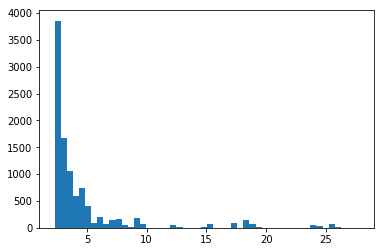

In [44]:
df_mcpacks = pd.DataFrame(columns=['Pack Value'])
for i in range(0,10000):
    df_mcpacks = df_mcpacks.append({'Pack Value':makePack(df_norm)['Price'].sum()},ignore_index=True)
plt.hist(df_mcpacks['Pack Value'],bins=50);

Now with Boxes!

In [45]:
def makeBox(set_df):
    box = pd.DataFrame()
    for i in range(0,36):
        box = box.append(makePack(set_df),ignore_index=True)
    return box   
        

In [46]:
#it works!
makeBox(df_norm)

,Edition,Rarity,Price,Card Name
0,Throne of Eldraine,Common,0.16,Merchant of the Vale // Haggle
1,Throne of Eldraine,Common,0.14,Tempting Witch
2,Throne of Eldraine,Common,0.16,Merfolk Secretkeeper // Venture Deeper
3,Throne of Eldraine,Common,0.14,Bartered Cow
4,Throne of Eldraine,Common,0.14,Run Away Together
5,Throne of Eldraine,Common,0.14,Lash of Thorns
6,Throne of Eldraine,Common,0.14,Ardenvale Tactician // Dizzying Swoop
7,Throne of Eldraine,Common,0.14,Rimrock Knight // Boulder Rush
8,Throne of Eldraine,Common,0.14,Brimstone Trebuchet
9,Throne of Eldraine,Common,0.14,Foreboding Fruit


In [47]:
print("$%.2f" % evpackmakeBox(df_norm)['Price'].sum())

179.67000000000002

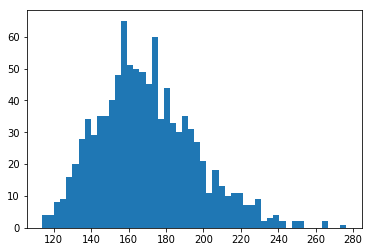

In [48]:
#Onward with the graphing
df_mcboxes = pd.DataFrame(columns=['Box Value'])
for i in range(0,1000):
    df_mcboxes = df_mcboxes.append({'Box Value':makeBox(df_norm)['Price'].sum()},ignore_index=True)
plt.hist(df_mcboxes['Box Value'],bins=50);